In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras 
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.layers import Dropout, MaxPooling2D, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import warnings
warnings.filterwarnings("ignore")

In [2]:
class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (220,220)

In [3]:
def load_data():
    
    datasets = ['/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                '/kaggle/input/chest-xray-pneumonia/chest_xray/test']
    images = []
    labels = []

    count =0
    for dataset in datasets:

        for folder in os.listdir(dataset):

            if folder in ['NORMAL']: label = 0
            elif folder in ['PNEUMONIA']: label = 1

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                try:
                    image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
                except:
                    continue
                images.append(image)
                labels.append(label)
            print()

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [4]:
images, labels = load_data()

100%|██████████| 3875/3875 [01:36<00:00, 40.07it/s]


100%|██████████| 1341/1341 [01:07<00:00, 19.76it/s]


100%|██████████| 390/390 [00:08<00:00, 43.52it/s]


100%|██████████| 234/234 [00:10<00:00, 22.68it/s]


In [6]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.23)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [7]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training samples: {}".format(n_train))
print("Number of validation samples: {}".format(n_val))
print("Number of test samples: {}".format(n_test))

print("Shape of training dataset: {}".format(train_images.shape))
print("Shape of training labels: {}".format(train_labels.shape))
print("Shape of validation dataset: {}".format(val_images.shape))
print("Shape of validation labels: {}".format(val_labels.shape))
print("Shape of test dataset: {}".format(test_images.shape))
print("Shape of test labels: {}".format(test_labels.shape))


Number of training samples: 4496
Number of validation samples: 672
Number of test samples: 672
Shape of training dataset: (4496, 220, 220, 3)
Shape of training labels: (4496,)
Shape of validation dataset: (672, 220, 220, 3)
Shape of validation labels: (672,)
Shape of test dataset: (672, 220, 220, 3)
Shape of test labels: (672,)


In [8]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

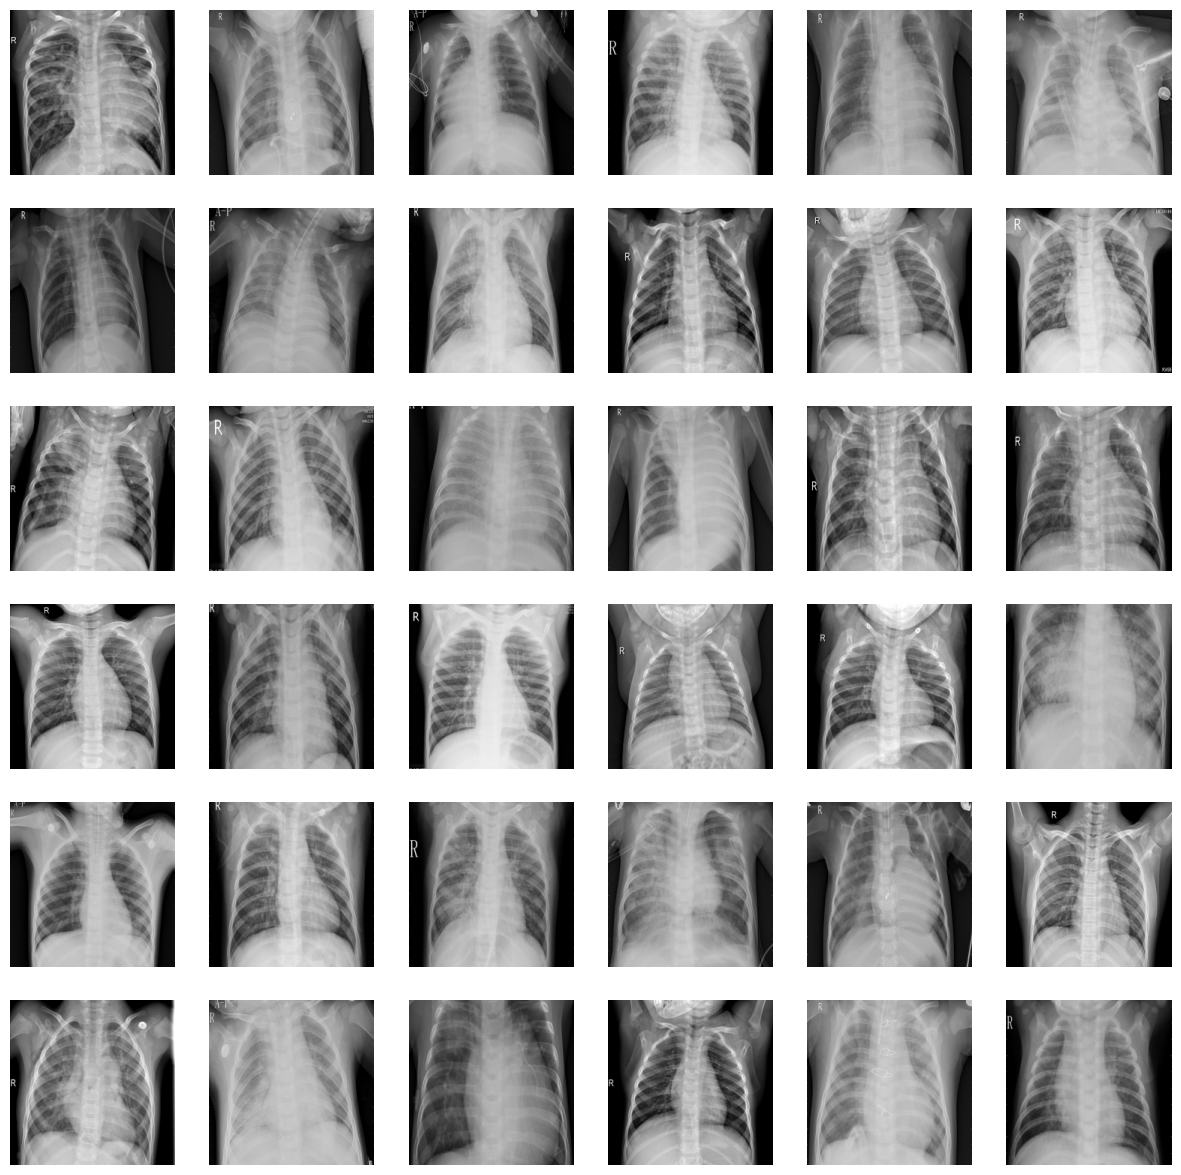

In [9]:
plt.figure(figsize=(15,15))
for n,i in enumerate(list(np.random.randint(0,len(train_images),36))):
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.axis("off")

<h1 id="aa" style="color:white;background:#1a3cab;padding:8px;border-radius:8px"> Моделирование </h1>

## Подключение ResNet50


![ResNet](https://upload.wikimedia.org/wikipedia/commons/9/98/ResNet50.png)


In [12]:
weights_path="/kaggle/input/weight/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
resnet50 = ResNet50V2(weights=weights_path, input_shape=(220, 220, 3), include_top=False)


In [14]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))



In [15]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,410,113
Trainable params: 12,845,313
Non-trainable params: 23,564,800
_________________________________________________________________


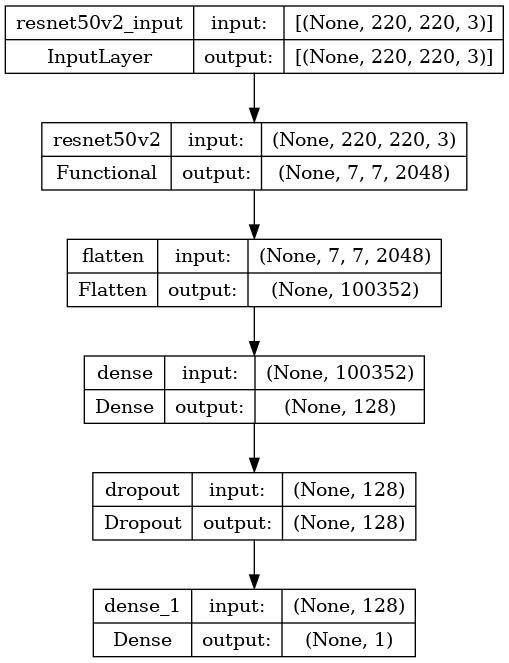

In [17]:
tf.keras.utils.plot_model(
    model, show_layer_names=True, show_shapes=True)

## Обучение модели

In [19]:
history = model.fit(
    x = train_images, 
    y = train_labels, 
    batch_size = 16, 
    epochs = 10, 
    validation_data=(val_images, val_labels)
)

Epoch 1/10
281/281 [==============================] - 457s 2s/step - loss: 0.1419 - accuracy: 0.9468 - val_loss: 0.1538 - val_accuracy: 0.9702
Epoch 2/10
281/281 [==============================] - 453s 2s/step - loss: 0.1076 - accuracy: 0.9540 - val_loss: 0.1113 - val_accuracy: 0.9688
Epoch 3/10
281/281 [==============================] - 492s 2s/step - loss: 0.1188 - accuracy: 0.9571 - val_loss: 0.1294 - val_accuracy: 0.9747
Epoch 4/10
281/281 [==============================] - 460s 2s/step - loss: 0.0994 - accuracy: 0.9595 - val_loss: 0.2203 - val_accuracy: 0.9479
Epoch 5/10
281/281 [==============================] - 468s 2s/step - loss: 0.0858 - accuracy: 0.9669 - val_loss: 0.1237 - val_accuracy: 0.9673
Epoch 6/10
281/281 [==============================] - 463s 2s/step - loss: 0.0706 - accuracy: 0.9691 - val_loss: 0.0898 - val_accuracy: 0.9732
Epoch 7/10
281/281 [==============================] - 460s 2s/step - loss: 0.0590 - accuracy: 0.9733 - val_loss: 0.1572 - val_accuracy: 0.9598

<h1 id="aa" style="color:white;background:#1a3cab;padding:8px;border-radius:8px"> Оценка модели </h1>

In [20]:
scores = model.evaluate(test_images, test_labels)
print("Accuracy on test data: %.2f%%" % (scores[1] * 100))

21/21 [==============================] - 69s 3s/step - loss: 0.1471 - accuracy: 0.9658
Accuracy on test data: 96.58%


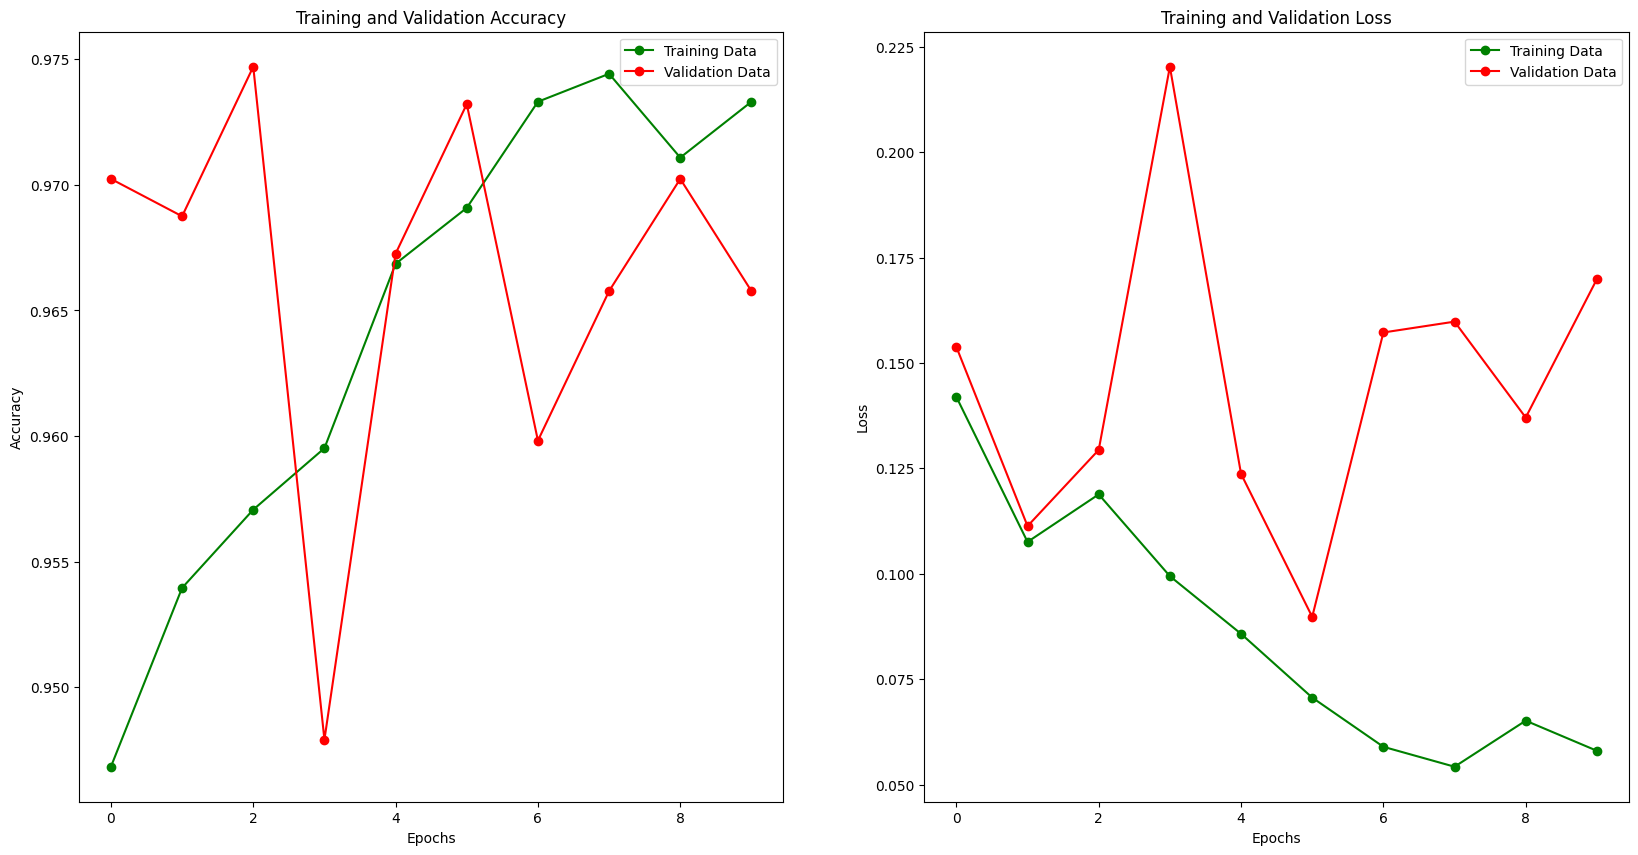

In [23]:
history = history
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1, 2)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20, 10)

# Accuracy Plot
ax[0].plot(epochs, train_acc, 'go-', label='Training Data')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Data')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Loss Plot
ax[1].plot(epochs, train_loss, 'g-o', label='Training Data')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Data')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


Actual Class: NORMAL
21/21 [==============================] - 57s 3s/step
Predicted Class: PNEUMONIA 



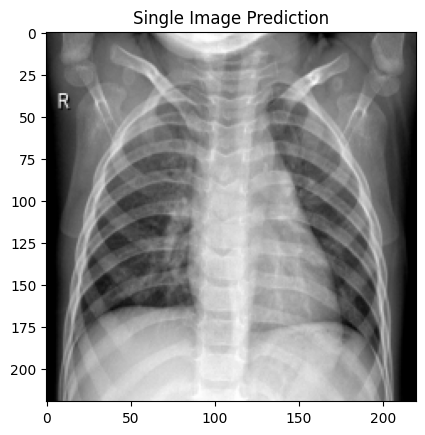

In [25]:
first_image = test_images[0]
first_label = test_labels[0]

plt.title("Single Image Prediction")
plt.imshow(first_image)
print("Actual Class:", class_names[first_label])

predictions = model.predict(test_images)
print("Predicted Class:", class_names[int(np.ceil(predictions[0]))], '\n')


In [4]:
model.save("/kaggle/working/pneumonia_model.h5")


NameError: name 'model' is not defined

In [27]:
from shutil import copyfile
copyfile("/kaggle/working/pneumonia_model.h5", "/kaggle/working/pneumonia_model_download.h5")


'/kaggle/working/pneumonia_model_download.h5'